In [30]:
#This code was in the site given in the project description
#This function uses the pickle library to convert the
#serialized binary data to a dictionary format
#(key -> object_name, values -> images in tensor form)

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


In [31]:
import numpy as np

# Initialize empty lists to store data and labels from each batch
train_images_list = []
train_labels_list = []

# Loop through each train batch
for i in range(1, 6):  # Batches are numbered 1 to 5
    # Load data from the current batch
    train_data = unpickle(f"data_batch_{i}")

    train_images_list.append(np.array(train_data[b"data"]))

    train_labels_list.append(np.array(train_data[b"labels"]))

# Concatenate all batch data into a single array
train_images = np.concatenate(train_images_list, axis=0)

# Concatenate all batch labels into a single array
train_labels = np.concatenate(train_labels_list, axis=0)

print(f"data -> {train_images.shape}")
print(f"labels -> {train_labels.shape}")

#Load test data
test_data = unpickle("test_batch")
test_images = np.array(test_data[b"data"])  # Shape: (10000, 3072)
test_labels = np.array(test_data[b"labels"])  # Shape: (10000,)

print(f"data -> {test_images.shape}")
print(f"labels -> {test_labels.shape}")

# Reshape images to (N, 32, 32, 3)
train_images = train_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
test_images = test_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

print("Training set shape:", train_images.shape)  # (50000, 32, 32, 3)
print("Test set shape:", test_images.shape)  # (10000, 32, 32, 3)

#as per the site the meta file in the folder contains class names so loading and checking

meta_data = unpickle("batches.meta")

class_names = [name.decode("utf-8") for name in meta_data[b"label_names"]]
print(class_names)



data -> (50000, 3072)
labels -> (50000,)
data -> (10000, 3072)
labels -> (10000,)
Training set shape: (50000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


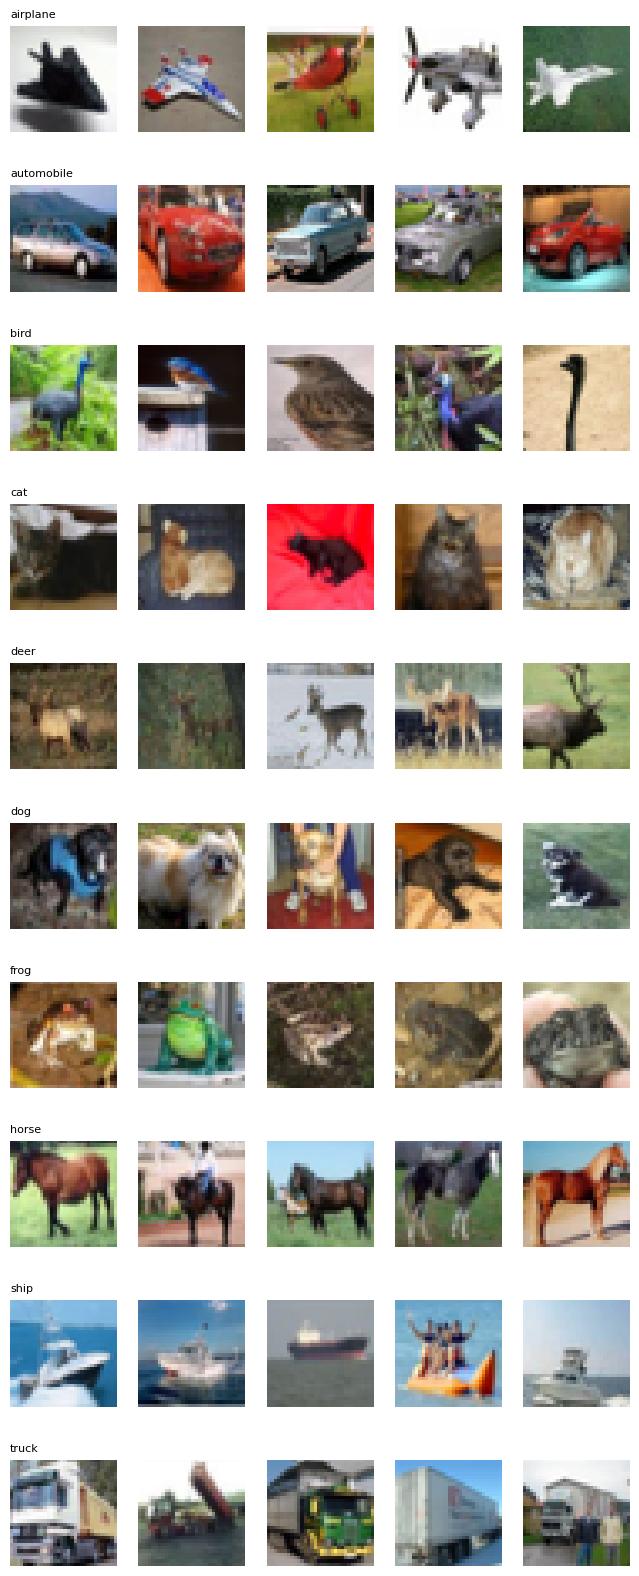

In [32]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(10, 5, figsize=(8, 20))  # 10 rows (classes), 5 columns (images per class)
plt.subplots_adjust(hspace=0.5)

for i in range(10):  # Loop through 10 classes
    class_indices = np.where(train_labels == i)[0]  # Find indices of this class
    selected_images = class_indices[:5]  # Pick first 5 images of this class

    for j, img_idx in enumerate(selected_images):
        ax = axes[i, j]
        ax.imshow(train_images[img_idx])
        ax.axis("off")
        if j == 0:  # Add label only to the first image in each row
            ax.set_title(class_names[i], fontsize=8, loc='left')

plt.show()


In [33]:
import numpy as np

def pca_fit(images, variance_ratio=0.9):
    """Fit PCA on training images and return the transformation matrix."""
    N, H, W, C = images.shape
    flattened_images = images.reshape(N, -1)

    mean = np.mean(flattened_images, axis=0)
    std = np.std(flattened_images, axis=0) + 1e-10
    standardized_images = (flattened_images - mean) / std

    covariance_matrix = np.cov(standardized_images, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    total_variance = np.sum(eigenvalues)
    explained_variance = np.cumsum(eigenvalues) / total_variance

    optimal_components = np.argmax(explained_variance >= variance_ratio) + 1
    print(f"Optimal number of components: {optimal_components}")

    top_eigenvectors = eigenvectors[:, :optimal_components]
    reduced_train = np.dot(standardized_images, top_eigenvectors)

    return mean, std, top_eigenvectors, reduced_train

def pca_transform(images, mean, std, top_eigenvectors):
    """Transform test images using PCA computed from training images."""
    N, H, W, C = images.shape
    flattened_images = images.reshape(N, -1)

    standardized_images = (flattened_images - mean) / std
    reduced_data = np.dot(standardized_images, top_eigenvectors)

    return reduced_data

# Apply PCA only on train data
mean, std, top_eigenvectors, train_pca = pca_fit(train_images, variance_ratio=0.9)

# Transform test data using the same PCA components
test_pca = pca_transform(test_images, mean, std, top_eigenvectors)


Optimal number of components: 103


**Algorithm: Linear Regression**

In [34]:
import numpy as np
from sklearn.metrics import accuracy_score

# Initialize parameters
learning_rate = 0.01  # Reduced for stability
num_epochs = 500  # More epochs for convergence
num_features = train_pca.shape[1]  # Use PCA-reduced feature count

# Feature Scaling (Z-score normalization)
train_pca = (train_pca - np.mean(train_pca, axis=0)) / (np.std(train_pca, axis=0) + 1e-8)
test_pca = (test_pca - np.mean(test_pca, axis=0)) / (np.std(test_pca, axis=0) + 1e-8)

# Initialize weights and bias
weights = np.random.randn(num_features) * 0.01  # Small random values
bias = 0

# Training loop
for epoch in range(num_epochs):
    predictions = np.dot(train_pca, weights) + bias  # Linear regression hypothesis

    # Compute gradients (MSE loss function)
    errors = predictions - train_labels
    grad_w = (2 / len(train_pca)) * np.dot(train_pca.T, errors)
    grad_b = (2 / len(train_pca)) * np.sum(errors)

    # Update weights and bias
    weights -= learning_rate * grad_w
    bias -= learning_rate * grad_b

    # Check for NaNs to debug
    if np.isnan(weights).any() or np.isnan(bias):
        print(f"NaN encountered at epoch {epoch}, stopping training.")
        break

    # Print loss every 100 epochs
    if epoch % 100 == 0:
        mse = np.mean(errors ** 2)
        print(f"Epoch {epoch}: MSE = {mse:.4f}")

# Testing
test_predictions = np.dot(test_pca, weights) + bias

# Convert to class labels (0-9)
test_predictions = np.round(test_predictions).astype(int)
test_predictions = np.clip(test_predictions, 0, 9)

# Compute accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Optimized Manual Linear Regression Accuracy: {accuracy * 100:.2f}%")


Epoch 0: MSE = 28.5168
Epoch 100: MSE = 7.9727
Epoch 200: MSE = 7.6114
Epoch 300: MSE = 7.6051
Epoch 400: MSE = 7.6049
Optimized Manual Linear Regression Accuracy: 10.96%


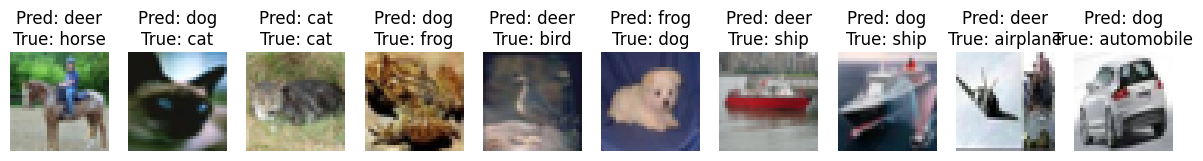

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# CIFAR-10 Class Names (Modify if using a different dataset)
class_names = ["airplane", "automobile", "bird", "cat", "deer",
               "dog", "frog", "horse", "ship", "truck"]

# Select some random test samples
num_samples = 10  # Change this to see more examples
indices = np.random.choice(len(test_pca), num_samples, replace=False)

fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

for i, idx in enumerate(indices):
    img = test_images[idx]  # Original image
    true_label = test_labels[idx]  # True class (0-9)
    predicted_label = test_predictions[idx]  # LR Predicted class (0-9)

    true_name = class_names[true_label]  # Convert to class name
    predicted_name = class_names[predicted_label]  # Convert to class name

    axes[i].imshow(img.astype("uint8"))  # Show image
    axes[i].axis("off")
    axes[i].set_title(f"Pred: {predicted_name}\nTrue: {true_name}")

plt.show()
